In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc

In [2]:
# create a dataframe to store the information
df = pd.DataFrame(columns=['text', 'relevant'])

handle = open('../Data/classify_rel_labeled_lemma.json')
for line in handle:
    item = json.loads(line)
    temp = pd.DataFrame([[item['text'], item['isRelevant']]], columns=['text', 'relevant'])
    df = df.append(temp, ignore_index=True)    
handle.close()
df['relevant'] = df['relevant'].astype(int)
print(df.head())

                                                text  relevant
0  destination charger charge normal car 7kw supe...         1
1  thanks making fricking spaceflight feel normal...         0
2          super charger working hard holiday season         1
3  egyptian bitch blush vintage tux dillinger tucked         0
4                 angel heaven silk bedding filled _         0


In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def calcScores(y, pred):
    averageType = "macro"
    accuracy = accuracy_score(y, pred)
    print("Accuracy: %0.4f" % (accuracy))
    recall = recall_score(y, pred, average=averageType)
    print("Recall: %0.4f" % recall)
    precision = precision_score(y, pred, average=averageType)
    print("Precision: %0.4f" % precision)
    f1 = f1_score(y, pred, average=averageType)
    print("F-Score: %0.4f" % f1)
    return accuracy, recall, precision, f1

##split data
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['relevant'], test_size=0.25, random_state=1)

In [4]:
##Naive Bayes
text_clf_pipe_nb = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('mnb', MultinomialNB(fit_prior=False)),])

text_clf_nb = text_clf_pipe_nb.fit(x_train, y_train)
train_pred_nb = text_clf_nb.predict(x_train)
test_pred_nb = text_clf_nb.predict(x_test)

print("-----Naive Bayes-----")
print("Train")
values_train_nb = calcScores(y_train, train_pred_nb)
print("\nTest")
values_test_nb = calcScores(y_test, test_pred_nb)

##SVM
from sklearn.linear_model import SGDClassifier
text_clf_pipe_svm = Pipeline([('vect', CountVectorizer()),
                              ('tfidf', TfidfTransformer()),
                              ('clf-svm', SGDClassifier(loss='log', 
                                                        penalty='l2', alpha=1e-3, 
                                                        max_iter=5, tol=None, 
                                                        random_state=42))])
text_clf_svm = text_clf_pipe_svm.fit(x_train, y_train)
train_pred_svm = text_clf_svm.predict(x_train)
test_pred_svm = text_clf_svm.predict(x_test)

print("\n-----SVM-----")
print("Train")
values_train_svm = calcScores(y_train, train_pred_svm)
print("\nTest")
values_test_svm = calcScores(y_test, test_pred_svm)
scores = np.column_stack((values_train_nb, values_train_svm, values_test_nb, values_test_svm))

-----Naive Bayes-----
Train
Accuracy: 0.9346
Recall: 0.9373
Precision: 0.9318
F-Score: 0.9338

Test
Accuracy: 0.8811
Recall: 0.8863
Precision: 0.8774
F-Score: 0.8795

-----SVM-----
Train
Accuracy: 0.7634
Recall: 0.7308
Precision: 0.8184
F-Score: 0.7330

Test
Accuracy: 0.7195
Recall: 0.6714
Precision: 0.7848
F-Score: 0.6648


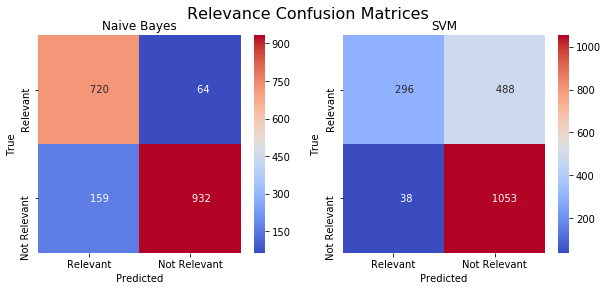

In [5]:
##plot confusion matrices
%matplotlib inline
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def normalizeCM(cm):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return cm

def createCmDf(cm):
    df_cm = pd.DataFrame(cm, index = ["Relevant", "Not Relevant"], columns = ["Relevant", "Not Relevant"])
    return df_cm

cm_nb = confusion_matrix(y_test,test_pred_nb, labels = [1, 0])

cm_svm = confusion_matrix(y_test,test_pred_svm, labels = [1, 0])

df_nb = createCmDf(cm_nb)
df_svm = createCmDf(cm_svm)

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10, 4))
fmt = '10d'
im = sn.heatmap(df_nb, ax=ax1, annot=True, cmap='coolwarm', fmt=fmt)
ax1.set_title("Naive Bayes")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("True")
sn.heatmap(df_svm, ax=ax2, annot=True, cmap='coolwarm', fmt=fmt)
ax2.set_title("SVM")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("True")
mappable = im.get_children()[0]
fig.suptitle('Relevance Confusion Matrices', fontsize=16)
plt.savefig('RelevanceConfusionMatrix.pdf')
plt.show();

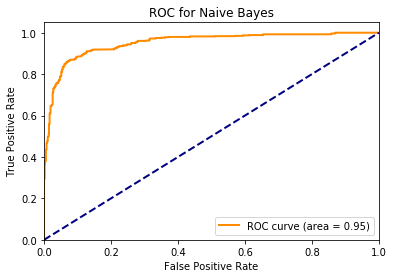

In [6]:
# ROC curves
pred_prob_nb = text_clf_nb.predict_proba(x_test)
fpr_nb, tpr_nb, _ = roc_curve(y_test, pred_prob_nb[:,1])
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.figure()
lw = 2
plt.plot(fpr_nb, tpr_nb, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Naive Bayes')
plt.legend(loc="lower right")
plt.show()

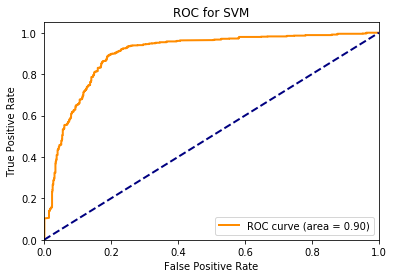

In [7]:
pred_prob_svm = text_clf_svm.predict_proba(x_test)
fpr_svm, tpr_svm, _ = roc_curve(y_test, pred_prob_svm[:,1])
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
lw = 2
plt.plot(fpr_svm, tpr_svm, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for SVM')
plt.legend(loc="lower right")
plt.show()

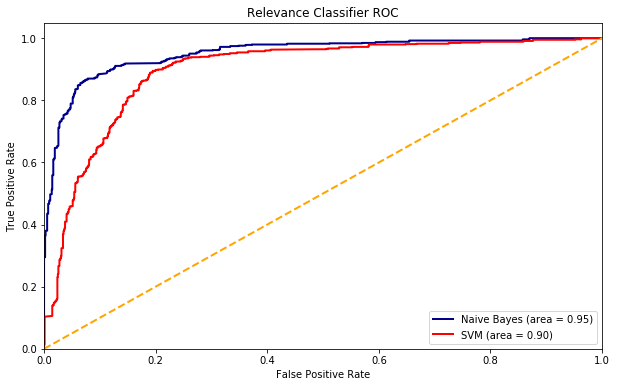

In [8]:
#Combined plot
plt.figure(figsize=(10,6))
lw = 2
plt.plot(fpr_nb, tpr_nb, color='darkblue',
         lw=lw, label='Naive Bayes (area = %0.2f)' % roc_auc_nb)
plt.plot(fpr_svm, tpr_svm, color='red',
         lw=lw, label='SVM (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='orange', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Relevance Classifier ROC')
plt.legend(loc="lower right")
plt.savefig("Relevance ROC.pdf")
plt.show()